In [2]:
# if running without local install
import sys, os
sys.path.append(os.path.abspath("..\\.."))

import GeoDataKit.geoplot as gp

import numpy as np
import pandas as pd

## Loading dataset
The dataset contains volcanic output locations from the eastern Velay, France.

Rocktype gives the type of rock of the volcanic output (felsic or mafic), points flagged as others correspond to intermediate rocktypes or maars.

In [16]:
data = pd.read_csv ("Pereira_etal_Velay.csv")

## Hough Study

### All points

In [18]:
velay_data = data[["x","y"]].to_numpy().T
velay_data

array([[ 3.962784,  3.963621,  3.9651  , ...,  4.172879,  4.17433 ,
         4.174411],
       [45.179533, 45.173771, 45.173001, ..., 44.88616 , 44.886388,
        44.88456 ]])

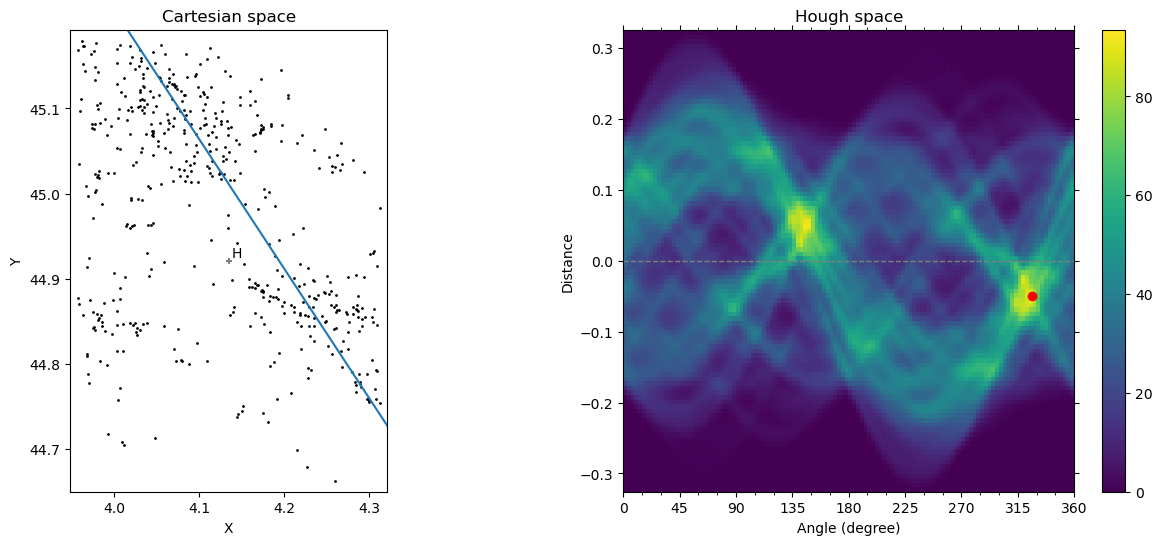

In [21]:
velay_data = data[["x","y"]].to_numpy().T
hgt = gp.HoughTransform(velay_data, update_area=True)
#hgt.select_data_point(2)
hgt.hough.update_accumulator(kernel_type="gaussian",sigma=0.01)
hgp = gp.HoughPlot(hgt)
hgp.plot(show_selected=False,
         show_circle=True,show_hough_point=True,show_triangle=True,
                      show_vector=True)
hgp.plot_manual(az=45, dist = 1)

In [19]:

n= 12
data_test = np.random.uniform(low=0,high=10,size=(2,n))
data_test

array([[2.13290211, 1.56368797, 5.74371208, 1.18527685, 3.73159598,
        4.95797508, 1.50775529, 0.19034631, 6.38787118, 1.0866796 ,
        8.01678572, 1.61398726],
       [3.37857787, 8.21119376, 6.02975812, 9.28699628, 2.35404737,
        5.93489724, 3.58157498, 7.16447029, 8.77187994, 6.8754669 ,
        3.08676789, 7.39012887]])

In [13]:
data.shape

(2, 12)

In [14]:
velay_data.shape

(505, 2)

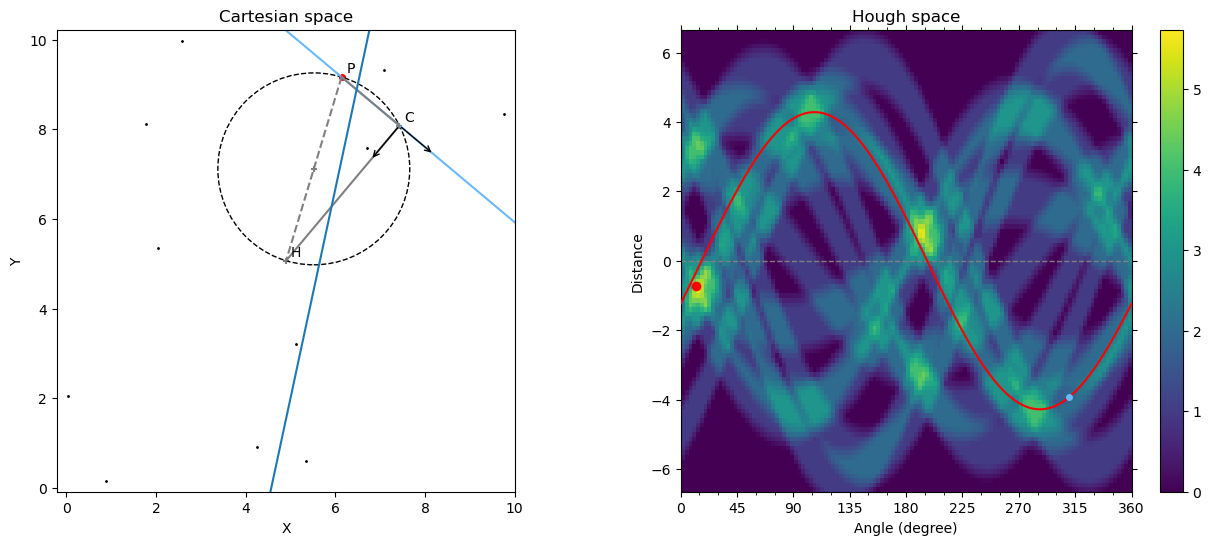

In [12]:
hgt = gp.HoughTransform(data,update_area=True)
hgt.select_data_point(2)
#hgt.hough.update_accumulator(kernel_type="triangle",sigma=1,trunc=True,max=1)
hgt.hough.update_accumulator(kernel_type="line",antialiase= True,width=1)
hgp = gp.HoughPlot(hgt)
hgp.plot(show_selected=True,index=2,az=310,
         show_circle=True,show_hough_point=True,show_triangle=True,
                      show_vector=True)

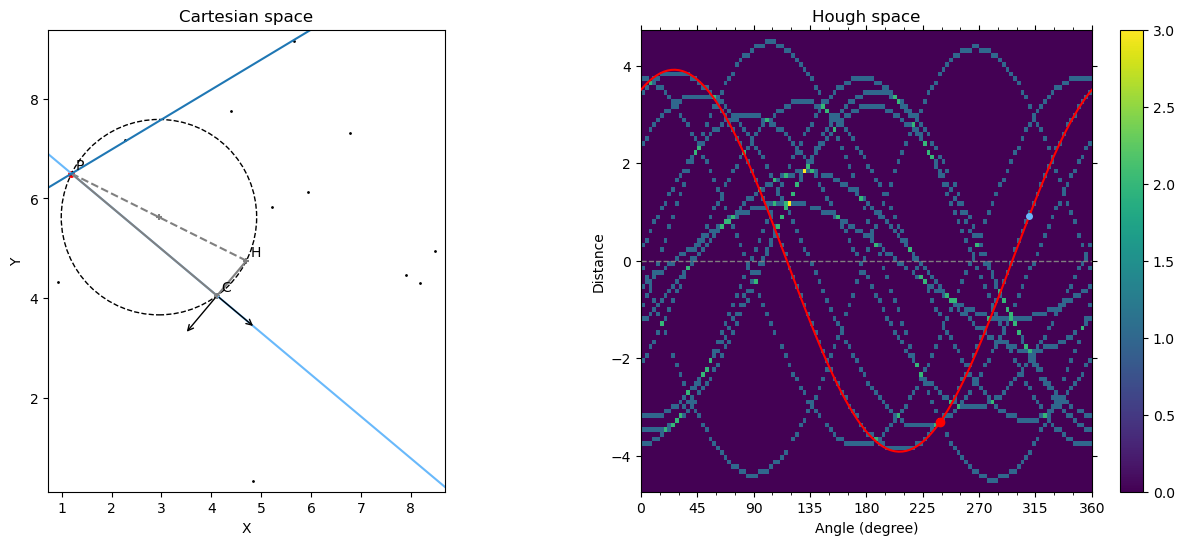

In [5]:
hgt = gp.HoughTransform(data,update_area=True)
hgt.select_data_point(2)
#hgt.hough.update_accumulator(kernel_type="triangle",sigma=1,trunc=True,max=1)
hgt.hough.update_accumulator(kernel_type="line",antialiase= False)
hgp = gp.HoughPlot(hgt)
hgp.plot(show_selected=True,index=2,az=310,
         show_circle=True,show_hough_point=True,show_triangle=True,
                      show_vector=True)

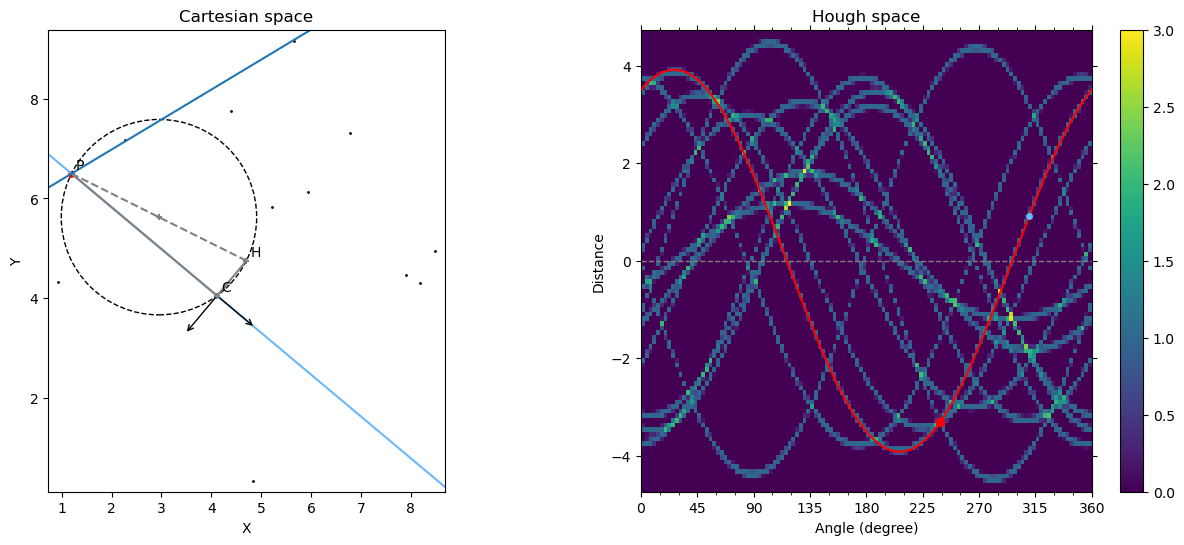

In [6]:
hgt = gp.HoughTransform(data,update_area=True)
hgt.select_data_point(2)
#hgt.hough.update_accumulator(kernel_type="triangle",sigma=1,trunc=True,max=1)
hgt.hough.update_accumulator(kernel_type="line",antialiase= True)
hgp = gp.HoughPlot(hgt)
hgp.plot(show_selected=True,index=2,az=310,
         show_circle=True,show_hough_point=True,show_triangle=True,
                      show_vector=True)

In [8]:
import ipywidgets as widgets
n= 10
data = np.random.uniform(low=0,high=10,size=(2,n))
hgt = gp.HoughTransform(data,update_area=True)
@widgets.interact(
    hgt=widgets.fixed(hgt),
    selected_index = widgets.IntSlider(value=0,min=0,max=n,step=1,continuous_update=False),
    selected_azimuth = widgets.IntSlider(value=45,min=0,max=360,step=1,continuous_update=False),
    azimuth = widgets.IntSlider(value=45,min=0,max=360,step=1,continuous_update=False),
    dist = widgets.FloatSlider(value=0,min=-hgt.hough.distance_max,max=hgt.hough.distance_max,step=0.1,continuous_update=False),
    sigma = widgets.FloatSlider(value=0.5,min=0.1,max=3,step=0.1,continuous_update=False),
    kernel = gp.kernel_dict.keys(),
    show_construction = [False,True]
)
def interact_hough(hgt,selected_index,selected_azimuth,azimuth,dist,sigma,kernel,show_construction):
    hgp = gp.HoughPlot(hgt)
    hgt.hough.update_accumulator(kernel_type=kernel,sigma=sigma)
    hgp.plot(show_selected=True,index=selected_index,az=selected_azimuth,
            show_circle=show_construction, show_triangle=show_construction,
            show_hough_point=show_construction, show_vector=show_construction)
    hgp.plot_manual(azimuth,dist)

interactive(children=(IntSlider(value=0, continuous_update=False, description='selected_index', max=10), IntSl…

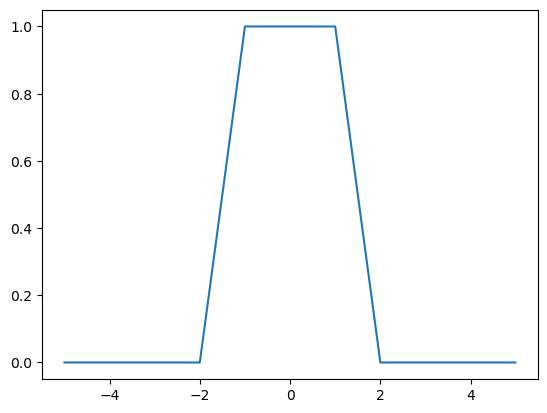

In [9]:
kernel = gp.HoughKernel.kernel(type="line",width=2)
delta = np.arange(-5,5,0.01)
gp.plt.plot(delta,kernel(delta))

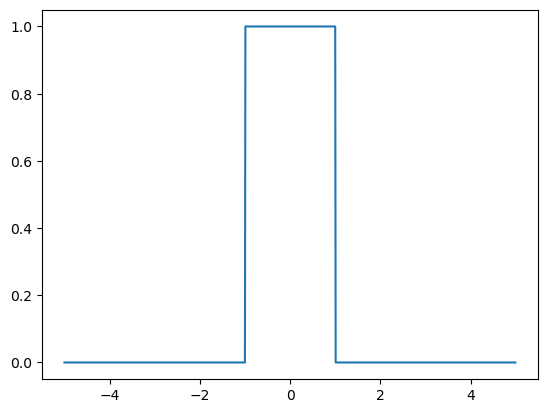

In [10]:
kernel = HoughKernel.kernel(type="line",width=2,antialiase=False)
delta = np.arange(-5,5,0.01)
plt.plot(delta,kernel(delta))

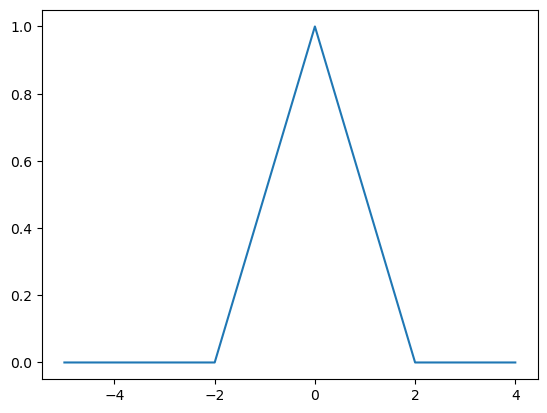

In [11]:
kernel = HoughKernel.kernel(type="triangle",sigma=2)
delta = np.arange(-5,5)
plt.plot(delta,kernel(delta))

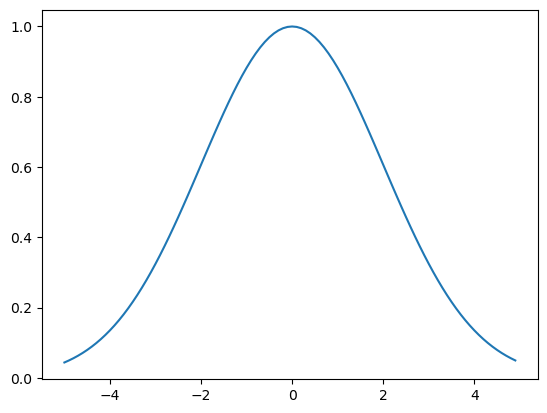

In [12]:
kernel = HoughKernel.kernel(type="gaussian",sigma=2)
delta = np.arange(-5,5,0.1)
plt.plot(delta,kernel(delta))